# Analysis tools

This is a rendered copy of [analysis_tools.ipynb](https://github.com/scikit-hep/coffea/blob/master/binder/analysis_tools.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fanalysis_tools.ipynb)

Now that we know how to access data with NanoEvents and apply corrections, let's go through some useful columnar analysis tools and idioms for building collections of results, namely, the eventual output of a coffea callable (or processor). The most familiar type of output may be the histogram (one type of accumulator).

We'll use our small sample file to demonstrate the utilities, although it won't be very interesting to analyze

In [1]:
import awkward as ak
from hist import Hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

NanoAODSchema.warn_missing_crossrefs = False

In [2]:
fname = "coffea/tests/samples/nano_dy.root"
access_log = []
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    mode="virtual",
    access_log=access_log,
).events()

To generate some mock systematics, we'll use one of the scale factors from the applying_corrections notebook (note you will have to at least execute the cell that downloads test data in that notebook for this to work)

In [3]:
from coffea.lookup_tools import extractor

ext = extractor()
ext.add_weight_sets(["* * data/testSF2d.histo.root"])
ext.finalize()
evaluator = ext.make_evaluator()
evaluator.keys()

dict_keys(['scalefactors_Tight_Electron', 'scalefactors_Tight_Electron_error'])

## Weights

This is a container for event weights and associated systematic shifts, which helps track the product of the weights (i.e. the total event weight to be used for filling histograms) as well as systematic variations to that product. Here we demo its use by constructing an event weight consisting of the generator weight, the $\alpha_s$ uncertainty variation, and the electron ID scale factor with its associated systematic.

In [4]:
from coffea.analysis_tools import Weights

weights = Weights(len(events))

weights.add("genWeight", events.genWeight)

weights.add(
    "alphaS",
    # in NanoAOD, the generator weights are already stored with respect to nominal
    weight=ak.ones_like(events.run, dtype=float),
    # 31 => alphas(MZ)=0.1165 central value; 32 => alphas(MZ)=0.1195
    # per https://lhapdfsets.web.cern.ch/current/PDF4LHC15_nnlo_30_pdfas/PDF4LHC15_nnlo_30_pdfas.info
    # which was found by looking up the LHA ID in events.LHEPdfWeight.__doc__
    weightUp=events.LHEPdfWeight[:, 32],
    weightDown=events.LHEPdfWeight[:, 31],
)

eleSF = evaluator["scalefactors_Tight_Electron"](events.Electron.eta, events.Electron.pt)
eleSFerror = evaluator["scalefactors_Tight_Electron_error"](events.Electron.eta, events.Electron.pt)
weights.add(
    "eleSF",
    # the event weight is the product of the per-electron weights
    # note, in a real analysis we would first have to select electrons of interest
    weight=ak.prod(eleSF, axis=1),
    weightUp=ak.prod(eleSF + eleSFerror, axis=1),
)

A [WeightStatistics](https://coffea-hep.readthedocs.io/en/latest/api/coffea.analysis_tools.WeightStatistics.html) object tracks the smallest and largest weights seen per type, as well as some other summary statistics. It is kept internally and can be accessed via `weights.weightStatistics`. This object is addable, so it can be used in an accumulator.

In [5]:
weights.weightStatistics

{'genWeight': WeightStatistics(sumw=578762.4375, sumw2=27678371840.0, minw=-26331.201171875, maxw=26331.201171875, n=40),
 'alphaS': WeightStatistics(sumw=40.0, sumw2=40.0, minw=1.0, maxw=1.0, n=40),
 'eleSF': WeightStatistics(sumw=38.26972579956055, sumw2=36.81547546386719, minw=0.6674144268035889, maxw=1.0077519416809082, n=40)}

Then the total event weight is available via

In [6]:
weights.weight()

array([ 26331.20117188,  23933.4196682 ,  24385.06528643,  17224.10489525,
        26331.20117188,  26535.31910775, -23236.21447283,  26067.890625  ,
        26331.20117188,  25105.68057538,  26331.20117188,  26061.82814944,
        26061.82814944, -26331.20117188,  26331.20117188,  24421.85661211,
       -24854.62516629,  26331.20117188, -19978.69273076,  26331.20117188,
        22168.68846612, -25134.17258657,  26331.20117188,  26331.20117188,
        26331.20117188,  24770.33051391,  26331.20117188,  22732.29949574,
        26331.20117188,  24421.85661211,  26331.20117188,  25857.1530546 ,
        26331.20117188, -23903.50101615,  26331.20117188, -24770.33051391,
        26331.20117188, -24906.05914783,  26331.20117188, -26331.20117188])

And the total event weight with a given variation is available via

In [7]:
weights.weight("eleSFUp")

array([ 26331.20117188,  24397.53583916,  25294.0252539 ,  17997.89462374,
        26331.20117188,  27253.27428405, -23502.68164558,  26067.890625  ,
        26331.20117188,  25230.22218679,  26331.20117188,  26779.78332574,
        26779.78332574, -26331.20117188,  26331.20117188,  24885.97278307,
       -24977.92136851,  26331.20117188, -20983.93483174,  26331.20117188,
        22734.27398292, -25869.18763094,  26331.20117188,  26331.20117188,
        26331.20117188,  25448.12088952,  26331.20117188,  22998.76666849,
        26331.20117188,  24885.97278307,  26331.20117188,  26254.27086417,
        26331.20117188, -24141.51091823,  26331.20117188, -25448.12088952,
        26331.20117188, -25583.84952343,  26331.20117188, -26331.20117188])

all variations tracked by the `weights` object are available via

In [8]:
weights.variations

{'alphaSDown', 'alphaSUp', 'eleSFDown', 'eleSFUp'}

## PackedSelection

This class can store several boolean arrays in a memory-efficient mannner and evaluate arbitrary combinations of boolean requirements in an CPU-efficient way. Supported inputs include 1D numpy or awkward arrays. This makes it a good tool to form analysis signal and control regions, and to implement cutflow or "N-1" plots.

Below we create a packed selection with some typical selections for a Z+jets study, to be used later to form same-sign and opposite-sign $ee$ and $\mu\mu$ event categories/regions.

In [9]:
from coffea.analysis_tools import PackedSelection

selection = PackedSelection()

selection.add("twoElectron", ak.num(events.Electron, axis=1) == 2)
selection.add("eleOppSign", ak.sum(events.Electron.charge, axis=1) == 0)
selection.add("noElectron", ak.num(events.Electron, axis=1) == 0)

selection.add("twoMuon", ak.num(events.Muon, axis=1) == 2)
selection.add("muOppSign", ak.sum(events.Muon.charge, axis=1) == 0)
selection.add("noMuon", ak.num(events.Muon, axis=1) == 0)


selection.add(
    "leadPt20",
    # assuming one of `twoElectron` or `twoMuon` is imposed, this implies at least one is above threshold
    ak.any(events.Electron.pt >= 20.0, axis=1) | ak.any(events.Muon.pt >= 20.0, axis=1),
)

print(selection.names)

['twoElectron', 'eleOppSign', 'noElectron', 'twoMuon', 'muOppSign', 'noMuon', 'leadPt20']


To evaluate a boolean mask (e.g. to filter events) we can use the `selection.all(*names)` function, which will compute the AND of all listed boolean selections

In [10]:
selection.all("twoElectron", "noMuon", "leadPt20")

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

We can also be more specific and require that a specific set of selections have a given value (with the unspecified ones allowed to be either true or false) using `selection.require`

In [11]:
selection.require(twoElectron=True, noMuon=True, eleOppSign=False)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

Using the python syntax for passing an arguments variable, we can easily implement a "N-1" style selection

In [12]:
allCuts = ["twoElectron", "noMuon", "leadPt20"]
results = {}
for cut in allCuts:
    nev = ak.sum(selection.all(*(set(allCuts) - {cut})), axis=0)
    results[cut] = nev

results["None"] = ak.sum(selection.all(*allCuts), axis=0)

for cut, nev in results.items():
    print(f"Events passing all cuts, ignoring {cut}: {nev}")

Events passing all cuts, ignoring twoElectron: 10
Events passing all cuts, ignoring noMuon: 3
Events passing all cuts, ignoring leadPt20: 5
Events passing all cuts, ignoring None: 3


Luckily coffea implements a helper for that and also for a "Cutflow" selection (with `.cutflow`)

In [13]:
nminusone = selection.nminusone("twoElectron", "noMuon", "leadPt20")
nminusone

NminusOne(selections=('twoElectron', 'noMuon', 'leadPt20'), commonmasked=False, weighted=False, weightsmodifier=None)

In [14]:
nminusone.print()

N-1 selection stats:

Ignoring twoElectron         pass = 10                  all = 40                  -- eff = 25.0 %

Ignoring noMuon              pass = 3                   all = 40                  -- eff = 7.5 %

Ignoring leadPt20            pass = 5                   all = 40                  -- eff = 12.5 %

All cuts                     pass = 3                   all = 40                  -- eff = 7.5 %

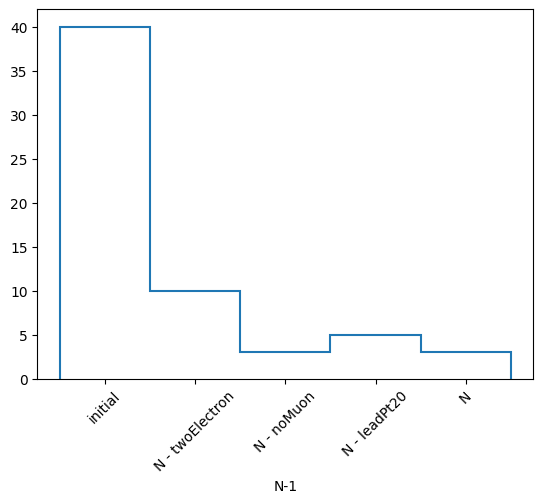

In [15]:
from matplotlib import pyplot as plt

h, labels = nminusone.yieldhist()
h.plot()
plt.xticks(plt.gca().get_xticks(), labels, rotation=45)
plt.show()

### Bringing it together

Let's build a callable function that books a few results, per dataset:
 - the sum of weights for the events processed, to use for later luminosity-normalizing the yields;
 - a histogram of the dilepton invariant mass, with category axes for various selection regions of interest and  systematics; and
 - the weight statistics, for debugging purposes

In [16]:
fname = "coffea/tests/samples/nano_dy.root"
access_log = []
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    mode="virtual",
    access_log=access_log,
).events()

In [17]:
def results_tg(events):
    regions = {
        "ee": {"twoElectron": True, "noMuon": True, "leadPt20": True, "eleOppSign": True},
        "eeSS": {"twoElectron": True, "noMuon": True, "leadPt20": True, "eleOppSign": False},
        "mm": {"twoMuon": True, "noElectron": True, "leadPt20": True, "muOppSign": True},
        "mmSS": {"twoMuon": True, "noElectron": True, "leadPt20": True, "muOppSign": False},
    }

    masshist = (
        Hist.new.StrCat(regions.keys(), name="region")
        .StrCat(["nominal"] + list(weights.variations), name="systematic")
        .Reg(60, 60, 120, name="mass", label="$m_{ll}$ [GeV]")
        .Weight()
    )

    for region, cuts in regions.items():
        goodevent = selection.require(**cuts)

        if region.startswith("ee"):
            leptons = events.Electron[goodevent]
        elif region.startswith("mm"):
            leptons = events.Muon[goodevent]
        lep1 = leptons[:, 0]
        lep2 = leptons[:, 1]
        mass = (lep1 + lep2).mass

        masshist.fill(
            region=region,
            systematic="nominal",
            mass=mass,
            weight=weights.weight()[goodevent],
        )
        for syst in weights.variations:
            masshist.fill(
                region=region,
                systematic=syst,
                mass=mass,
                weight=weights.weight(syst)[goodevent],
            )

    out = {
        events.metadata["dataset"]: {
            "sumw": ak.sum(events.genWeight, axis=0),
            "mass": masshist,
            "weightStats": weights.weightStatistics,
        }
    }
    return out

In [18]:
out = results_tg(events)
out

{'DYJets': {'sumw': np.float32(578762.44),
  'mass': Hist(
    StrCategory(['ee', 'eeSS', 'mm', 'mmSS'], name='region'),
    StrCategory(['nominal', 'eleSFDown', 'alphaSDown', 'alphaSUp', 'eleSFUp'], name='systematic'),
    Regular(60, 60, 120, name='mass', label='$m_{ll}$ [GeV]'),
    storage=Weight()) # Sum: WeightedSum(value=621215, variance=2.20829e+10),
  'weightStats': {'genWeight': WeightStatistics(sumw=578762.4375, sumw2=27678371840.0, minw=-26331.201171875, maxw=26331.201171875, n=40),
   'alphaS': WeightStatistics(sumw=40.0, sumw2=40.0, minw=1.0, maxw=1.0, n=40),
   'eleSF': WeightStatistics(sumw=38.26972579956055, sumw2=36.81547546386719, minw=0.6674144268035889, maxw=1.0077519416809082, n=40)}}}

The mass histogram itself is not very interesting with only 40 input events, however

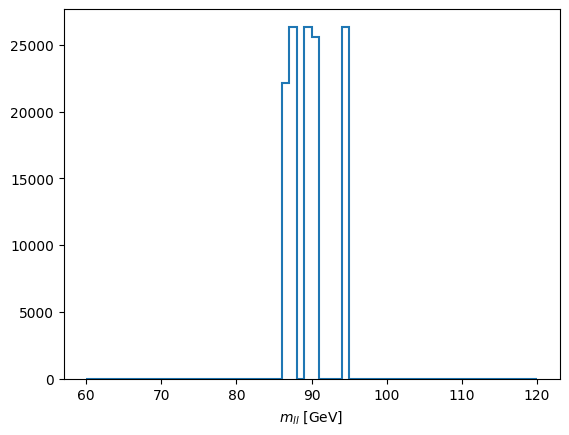

In [19]:
out["DYJets"]["mass"][sum, "nominal", :].plot(yerr=0);